# Spike count statistics

One plot:
> Raster plot

> Firing rates

> CV of ISI

> Synchrony

Further:
> Spike count distribution

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)
import helper_functions as hf; reload(hf)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
xfactor = 2.6
plt.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
plt.rcParams['figure.subplot.bottom'] =  0.25    # the bottom of the subplots of the figure
plt.rcParams['figure.subplot.top'] =  0.75    # the bottom of the subplots of the figure#figure.subplot.top     : 0.9    # the top of the subplots of the figure

figure_path = os.path.join(".", "figures")
reverse_order = True
colors = style.colors

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3.py:215: Warning: Source ID 6 was not found when attempting to remove it
  GLib.source_remove(self._idle_event_id)


### Raster plot

Prepare raster plot data

In [2]:
def raster_plot_results(sim_spec="raster_plot", reverse_order=True):
    data_path   = "/export/data-schuessler/data_microcircuit/micro"
    data_file_name  = sim_spec + ".hdf5"  
    path_data_file  = os.path.join(data_path, data_file_name)
    res_file_name   = sim_spec + "_res.hdf5"
    path_res_file   = os.path.join(data_path, res_file_name)

    with h5py.File(path_data_file, "r") as data_file:
        # Simulation attributes
        t_sim   = data_file.attrs["t_sim"]  
        t_trans = data_file.attrs["t_trans"]
        dt      = data_file.attrs["dt"]    
        populations   = data_file.attrs["populations"].astype("|U4")   
        n_populations = data_file.attrs["n_populations"]
        n_layers      = data_file.attrs["n_layers"]       
        n_types       = data_file.attrs["n_types"]

        grp = data_file["0/spikes"]
        dt = grp.attrs["dt"]
        n_neurons_rec_spike = grp.attrs["n_neurons_rec_spike"][:]

        t_measure = t_sim - t_trans

        if reverse_order: # Reverse the order
            offsets = np.append([0], np.cumsum(n_neurons_rec_spike[::-1]))
        else:
            offsets = np.append([0], np.cumsum(n_neurons_rec_spike))

        with h5py.File(path_res_file, "w") as  res_file:
            # Pass data to res_file:
            res_file.attrs["area"]             = data_file.attrs["area"]   
            res_file.attrs["t_sim"]            = data_file.attrs["t_sim"]  
            res_file.attrs["t_trans"]          = data_file.attrs["t_trans"]
            res_file.attrs["dt"]               = data_file.attrs["dt"]    
            res_file.attrs["populations"]      = data_file.attrs["populations"]
            res_file.attrs["layers"]           = data_file.attrs["layers"]       
            res_file.attrs["types"]            = data_file.attrs["types"]     
            res_file.attrs["n_populations"]    = data_file.attrs["n_populations"]
            res_file.attrs["n_layers"]         = data_file.attrs["n_layers"]       
            res_file.attrs["n_types"]          = data_file.attrs["n_types"] 

            for i, population in enumerate(populations):
                # Get data
                subgrp = grp[str(population)]
                raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
                indices         = subgrp["rec_neuron_i"][:]

                # Create results subgroup
                res_raster_pop = res_file.create_group(str(population))

                rnd_js = np.random.permutation(n_neurons_rec_spike[i])
                for j in range(n_neurons_rec_spike[i]):
                    times = raw_times_all[indices[j]:indices[j+1]]
                    times = times[times > t_trans]

                    if reverse_order:
                        neuron_ids_raster   = [-rnd_js[j]]*len(times) + offsets[::-1][i]
                    else:
                        neuron_ids_raster   = [rnd_js[j]]*len(times) + offsets[i]
                    raster_data         = np.vstack((times, neuron_ids_raster))
                    res_raster_pop.create_dataset(str(j), data=raster_data)

            res_file.attrs["ymax_raster"] = offsets[-1]
            res_file.attrs["yticks"] = (offsets[1:] - offsets[:-1]) * 0.5 + offsets[:-1]
            res_file.attrs["n_neurons_rec_spike"] = n_neurons_rec_spike

In [3]:
def plot_raster(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    with h5py.File(path_res_file, "r") as res_raster:
        ymax_raster = res_raster.attrs["ymax_raster"]
        yticks = res_raster.attrs["yticks"]

        for i, population in enumerate(populations):
            res_raster_pop = res_raster[str(population)]
            for times, neuron_ids in res_raster_pop.values():
                ax.plot(times * 1e3, neuron_ids, '.', ms=5, color=colors[i])              

    # Raster Plot
    xlim = (t_trans * 1e3, t_sim * 1e3) 
    ylim = (0, ymax_raster)
    xticks = np.linspace(100, 500, 5)
    yticklabels = hf.rlbl(populations)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('simulation time / ms')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

save figure to raster_plot


/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


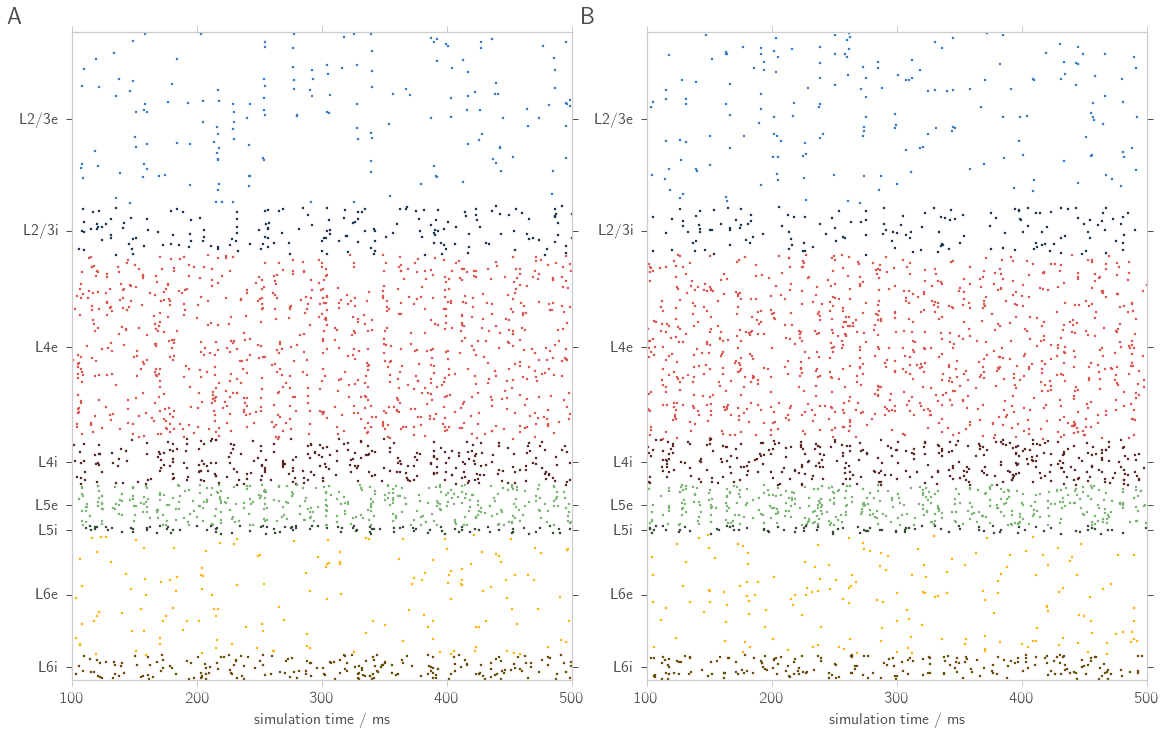

In [4]:
fig = plt.figure()
ax0 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 0), rowspan=1, colspan=1)
ax1 = hf.add_subplot(fig, n_rows_cols=(1, 2), index_row_col=(0, 1), rowspan=1, colspan=1)
plot_labels = list("AB")

for ax, sli, plot_label in zip(fig.axes, [False, True], plot_labels):
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    raster_sim_spec = "raster_plot"
    if sli:
        raster_sim_spec += "_sli"
    #raster_plot_results(sim_spec=raster_sim_spec, reverse_order=reverse_order) # produces results file
    res_file_name = raster_sim_spec + "_res.hdf5"
    path_res_file = os.path.join(data_path, res_file_name)

    plot_raster(ax, path_res_file)

    # General rendering
    ax.grid(False)
    style.fixticks(ax)

    # Label subfigures
    ax.text(-0.1, 1.04, plot_label, transform=ax.transAxes,
            fontsize=24, fontweight='bold', va='top', ha='right')  

fig_name = "raster_plot"
if save_fig:
    print("save figure to " + fig_name) 
    fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
    fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  

## Boxplot

In [5]:
def plot_rates(ax, path_res_file, n_spikes_recorded=1000, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

    single_rates = np.empty((n_populations, n_spikes_recorded))
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0/single_rates"]
        for i, population in enumerate(populations):
            if reverse_order:
                single_rates[-(i + 1)] = res_grp[population][:]
            else:
                single_rates[i] = res_grp[population][:]

    flierprops  = dict(marker='+', markersize=8,
                      linestyle='None', mew=1)
    medianprops = dict(color='k')
    box = ax.boxplot(single_rates.T,
                     vert=False, showfliers=True, 
                     flierprops=flierprops, medianprops=medianprops,
                     patch_artist=True)
    
    if reverse_order:
        box_colors = colors[::-1]
    else:
        box_colors = colors[:]
    for i, population in enumerate(populations):
        box["boxes"][i].set_alpha(0.8)
        box["boxes"][i].set_facecolor(box_colors[i])
        box["fliers"][i].set_color(box_colors[i])
        box["whiskers"][2*i].set_color(box_colors[i])
        box["whiskers"][2*i+1].set_color(box_colors[i])
        box["caps"][2*i].set_color(box_colors[i])
        box["caps"][2*i+1].set_color(box_colors[i])


    yticks = np.arange(n_types * 0.75, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations + 1.0)
    
    ax.set_xlabel('firing rate / Hz')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)
    ax.grid(False)

## CV of ISI

In [6]:
def plot_CV_ISI(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    # Open file: results
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0"]
        cv_isi_mean  = res_grp["cv_isi_mean"][:]

    ys = np.arange(n_populations) + 0.1
    if reverse_order:
        ys = ys[::-1]
    bar_height = 0.8 
    for i, population in enumerate(populations):
        ax.barh(ys[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)

    yticks = np.arange(n_types * 0.5, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations)
    
    ax.set_xlabel('CV of interspike intervals / Hz')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)

##  Synchrony

In [7]:
def plot_synchrony(ax, path_res_file, reverse_order=True):
    (area, t_sim, t_trans, t_measure, dt, 
            populations, layers, types, 
            n_populations, n_layers, n_types) = hf.basic_data(path_res_file)
    # Open file: results
    with h5py.File(path_res_file, "r") as res_file:
        res_grp = res_file["0"]
        synchrony    = res_grp["synchrony"][:]

    ys = np.arange(n_populations) + 0.1
    if reverse_order:
        ys = ys[::-1]
    bar_height = 0.8 
    for i, population in enumerate(populations):
        ax.barh(ys[i], synchrony[i],   height=bar_height, color=colors[i], linewidth=0)    
    
    yticks = np.arange(n_types * 0.5, n_populations, n_types)
    yticklabels = hf.rlbl(layers)
    if reverse_order:
        yticklabels = yticklabels[::-1]
    ylim = (0, n_populations)
    
    ax.set_xlabel('Synchrony')
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylim(*ylim)

## Plotting rates, CV of ISI and synchrony

save figure to spontaneous_activity


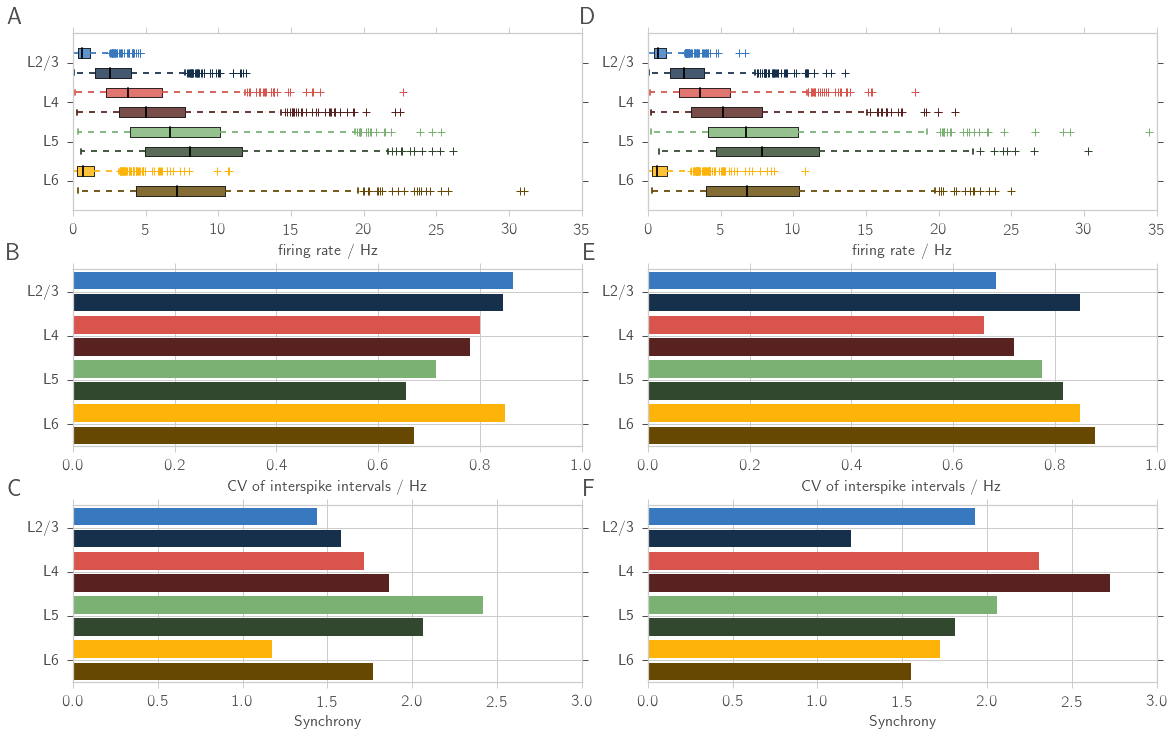

In [8]:
fig = plt.figure()

for i, sli in enumerate([False, True]):
    # DATA
    data_path = "/export/data-schuessler/data_microcircuit/micro"
    sim_spec = "spontaneous_activity"
    if sli:
        sim_spec += "_sli"
    data_file_name  = sim_spec + ".hdf5"  
    res_file_name = sim_spec + "_res.hdf5"
    path_data_file = os.path.join(data_path, data_file_name)
    path_res_file = os.path.join(data_path, res_file_name)

    # Rates
    ax1 = hf.add_subplot(fig, n_rows_cols=(3, 2), index_row_col=(0, i), rowspan=1, colspan=1)
    plot_rates(ax1, path_res_file, n_spikes_recorded=1000)
    # CV of interspike interval (ISI)
    ax2 = hf.add_subplot(fig, n_rows_cols=(3, 2), index_row_col=(1, i), rowspan=1, colspan=1)
    plot_CV_ISI(ax2, path_res_file)
    ax2.set_xlim(0, 1)
    # Synchrony
    ax3 = hf.add_subplot(fig, n_rows_cols=(3, 2), index_row_col=(2, i), rowspan=1, colspan=1)
    plot_synchrony(ax3, path_res_file)
    ax3.set_xlim(0, 3.)

# Label subfigures
plot_labels = list('ABCDEF')
for ax, label in zip(fig.axes, plot_labels):
    ax.text(-0.1, 1.15, label, transform=ax.transAxes,
            fontsize=24, fontweight='bold', va='top', ha='right')    
    # General rendering

    style.fixticks(ax)
    
fig_name = "spontaneous_activity"
if save_fig:
    print("save figure to " + fig_name) 
    fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), bbox_inches='tight', format="pdf")
    fig.savefig(os.path.join(figure_path, fig_name + ".png"), bbox_inches='tight', format="png")  

## Spike count statistics

This is equivalent to looking more closely behind the distributions shown in the box plot of single neuron firing rates.

The theoretical distributions are those for poisson processes with the corresponding mean rate. 

In [9]:
data_path = "/export/data-schuessler/data_microcircuit/micro"
sim_spec = "spontaneous_activity"
data_file_name  = sim_spec + ".hdf5" 
path_data_file = os.path.join(data_path, data_file_name)
res_file_name  = sim_spec + "_res.hdf5" 
path_res_file = os.path.join(data_path, res_file_name)

In [10]:
(area, t_sim, t_trans, t_measure, dt, 
        populations, layers, types, 
        n_populations, n_layers, n_types) = hf.basic_data(path_res_file)

with h5py.File(path_res_file, "r") as res_file:
    res_grp = res_file["0"]
    rates_mean  = res_grp["rates_mean"][:]
    
n_bins         = 2000
bins           = np.arange(0, n_bins)
hist_n_spikes  = np.zeros((n_populations, n_bins))           
    
with h5py.File(path_data_file, "r") as  data_file:
    grp = data_file["0/spikes"]

    for i, population in enumerate(populations):
        subgrp = grp[str(population)]
        raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
        indices         = subgrp["rec_neuron_i"][:]

        n_spikes_total = np.zeros(len(indices) - 1)
        for j in range(len(indices) - 1):
            times = raw_times_all[indices[j]:indices[j+1]]
            times = times[times > t_trans]      
            n_spikes_total[j] = len(times)

        hist_n_spikes[i] = np.histogram(n_spikes_total, bins=n_bins, 
                                         range=(0, n_bins), density=False)[0]

<n>	var[n]	fano
 52.82	2263.16	 42.85
180.64	15590.84	 86.31
save figure to isi_histo_spontaneous_activity_7
270.82	32968.21	121.74
350.56	48720.29	138.98
save figure to isi_histo_spontaneous_activity_7
450.97	77194.14	171.18
522.52	83362.02	159.54
save figure to isi_histo_spontaneous_activity_7
 66.58	6041.46	 90.74
475.15	79112.28	166.50
save figure to isi_histo_spontaneous_activity_7


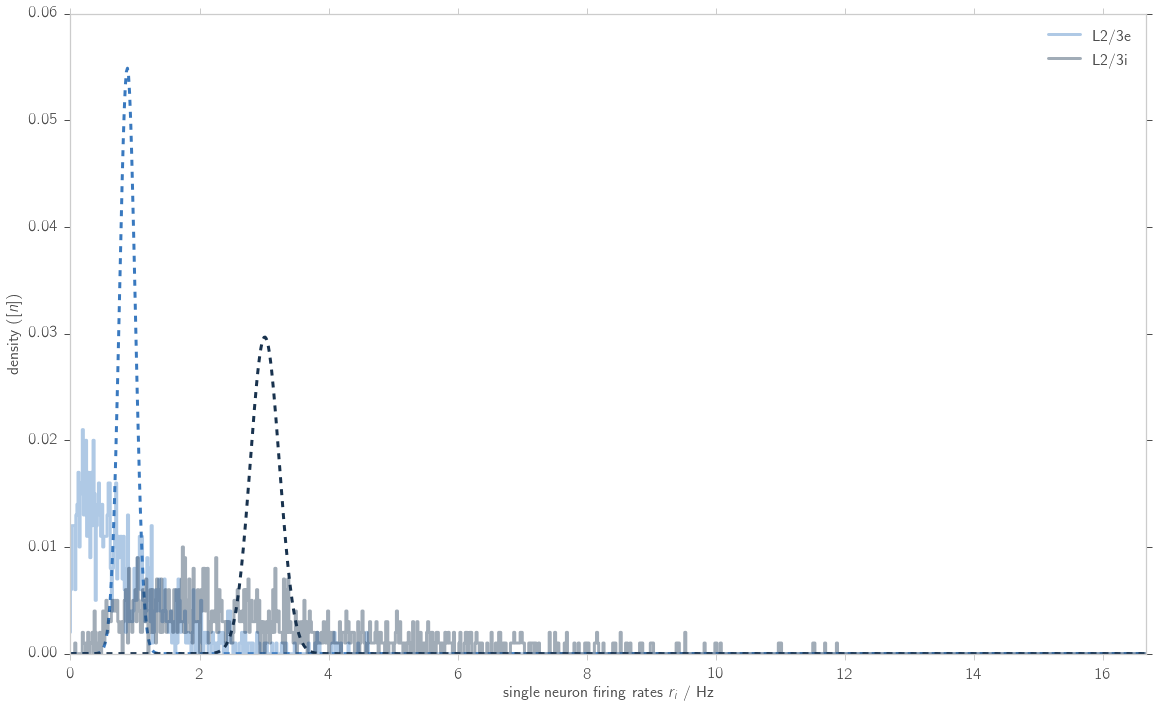

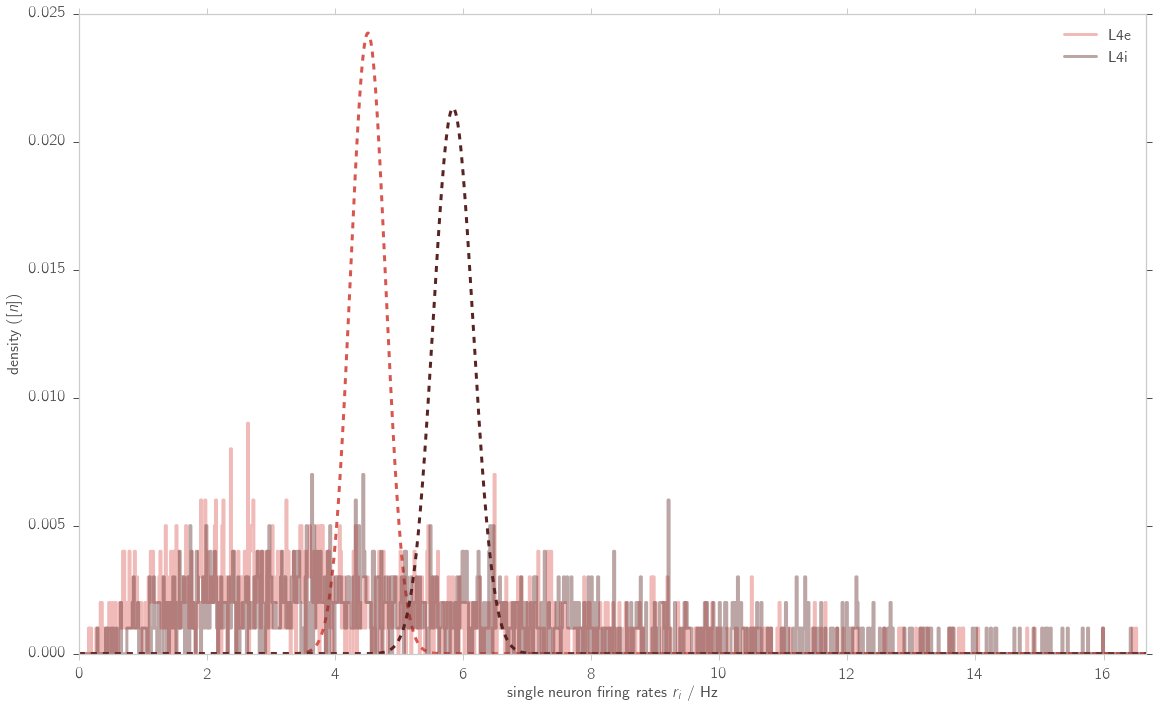

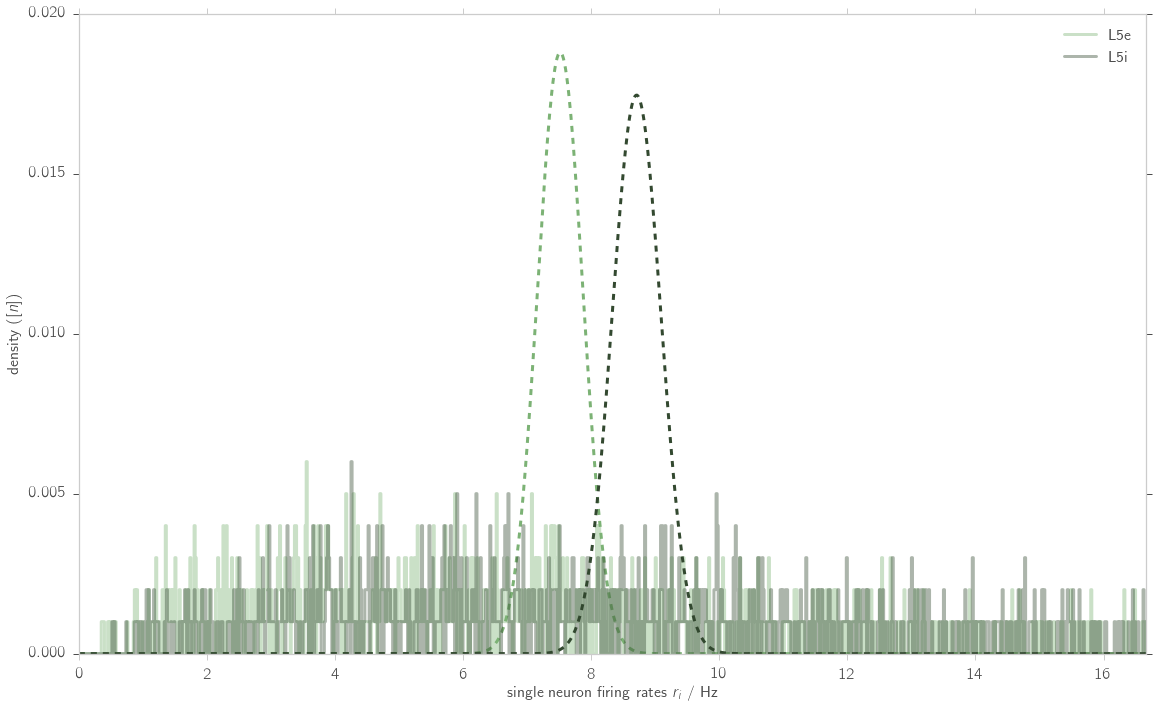

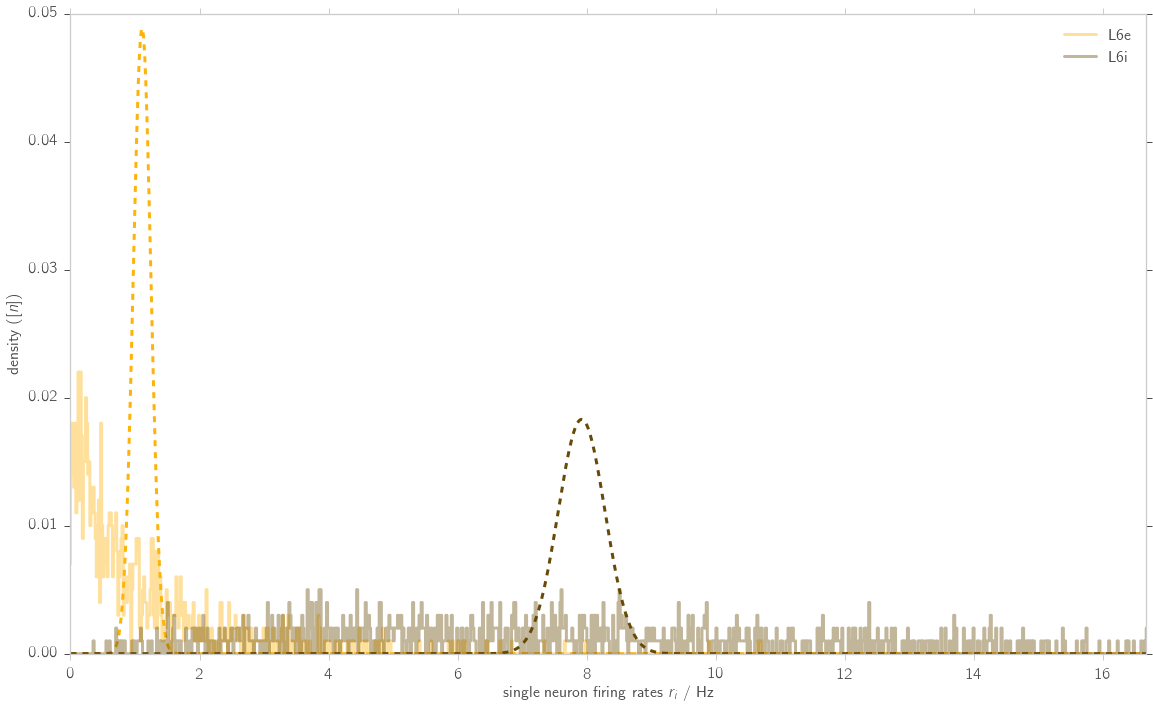

In [11]:
## Theory: P_T[n] = (r * T)**(n) / n! * exp(-r * T)
def P_n_spikes(n, rate, T=t_measure):
    from scipy.misc import factorial
    return (rate * T)**n / factorial(n) * np.exp(-rate * T)
def gauss(n, rate, T=t_measure):
    mu = rate * T
    sigma = np.sqrt(mu)
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (n - mu)**2 / (2 * sigma**2))

print("<n>\tvar[n]\tfano")
for l, layer in enumerate(layers):
    fig = plt.figure()

    ax = hf.add_subplot(fig, n_rows_cols=(1, 1), index_row_col=(0, 0), rowspan=1, colspan=1)
    x_max = 0
    for i, population in enumerate(populations):
        if population.startswith(layer):
            ax.plot(bins / t_measure, hist_n_spikes[i] / np.sum(hist_n_spikes[i]), 
                     linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=hf.rlbl(population))
            

            rate = rates_mean[i]            
            mean = rate * t_measure
            var = np.dot(hist_n_spikes[i], bins ** 2) / np.sum(hist_n_spikes[i]) - mean**2
            fano_factor = var / mean
            print("{0:6.2f}\t{1:6.2f}\t{2:6.2f}".format(mean, var, fano_factor))

            # Plot expectations for poisson processes
            ax.plot(bins / t_measure, gauss(bins, rate), "--",
                     linewidth=3., color=colors[i], alpha=0.99)
        
            # calc the upper xlim
            new_x_max = mean + 2 * np.sqrt(mean)
            if new_x_max > x_max:
                x_max = new_x_max
            
    #ax.set_xlim(0, x_max)
    ax.set_ylabel('density $([n])$')
    ax.set_xlabel('single neuron firing rates $r_i$ / Hz')
    ax.set_xlim(0, 1000 / t_measure)
    ax.legend(loc="best")
    ax.grid(False)
    style.fixticks(ax)

    fig_name = "isi_histo_" + sim_spec

    fig_name += "_" + str(i)
    if save_fig:
        print("save figure to " + fig_name)
        fig.savefig(os.path.join(figure_path, fig_name + ".pdf"), format="pdf")
        fig.savefig(os.path.join(figure_path, fig_name + ".png"), format="png")
    else:
        suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
        suptitle += '\nfile: ' + sim_spec
        fig.suptitle(suptitle, y=0.98)